# Trabalho de implementação 1

Esse é o relatório e a implementação do __Trabalho de Implementação 1__ para a disciplina de __Fundamentos de Visão Computacional - INF01030__, ministrada pelo professor __Cláudio Jung__

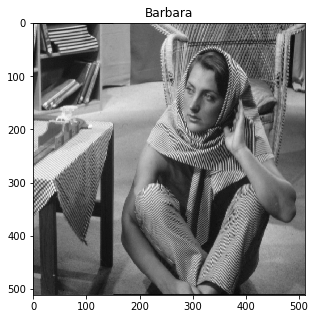

In [1]:
%matplotlib inline

# Imports
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pywt

# Basic function to display B&W image
def display_image(img, title='', figsize=(5, 5)):
    fig, axarr = plt.subplots(1, figsize=figsize)
    axarr.imshow(img, cmap="gray")
    axarr.set_title(title)
    
# Load barbara image
barbara = cv2.cvtColor(cv2.imread('barbara.jpg'), cv2.COLOR_BGR2GRAY)
display_image(barbara, "Barbara")

# Configure Haar filters
C = np.array([ np.sqrt(2) / 2,  np.sqrt(2) / 2])
D = np.array([-np.sqrt(2) / 2,  np.sqrt(2) / 2])
F = np.array([ np.sqrt(2) / 2,  np.sqrt(2) / 2])
G = np.array([ np.sqrt(2) / 2, -np.sqrt(2) / 2])
haar = [C, D, F, G]

# Basic configuration for plots
titles = ["Image", "Vertical", "Horizontal", "Diagonal"]

## Questão 1

> Implemente uma transformada wavelet discreta (discrete wavelet transform, ou DWT) em 1D
  (direta e inversa) usando a noção de _filter banks_. O programa deve receber como entrada um
  sinal unidimensional, o nível máximo $J$ da decomposição, além dos 4 filtros necessários para a
  síntese/análise:
  
> * C: passa-baixas da decomposição
* D: passa-altas da decomposição
* F: passa-baixas da reconstrução
* G: passa-altas da reconstrução

> O programa deve gerar como saída o sinal suavizado $A_{2^j}[n]$, além dos sinais de detalhe $D_{2^j}[n]$,
  $j = 1, ..., J$. Dica: o comando $Wavelet$ do módulo $PyWavelets$ (https://pypi.org/project/PyWavelets) da linguagem Python fornece os coeficientes de várias famílias wavelet para teste.
  O módulo também fornece implementações para a DWT, mas você deverá implementar a sua
  transformada. No seu relatório, coloque resultados numéricos da sua rotina (coeficientes da DTW
  da transformada direta e o sinal reconstruído com a transformada inversa) aplicada ao seguinte sinal usando wavelets _Haar_   com $J = 2$: $x = [1, 2, -1, 3, 6, -2, -1, 3]$

### Implementação

In [2]:
def _wavelet_1d(signal, filters):
    '''
        Private unction which applies a wavelet transformation in a `signal`.
        The `filters` array must be in the order `[C, D, F, G]`
    '''
    C, D, _, _ = filters

    # Convolution between signal and C for low-pass or D for high-pass
    y0 = np.convolve(signal, C)
    y1 = np.convolve(signal, D)

    # Downsampling, getting every other value
    v0 = y0[1::2]
    v1 = y1[1::2]
    
    # return signal, detail
    return v0, v1

def wavelet_1d(signal, filters, J=2):
    '''
        Function which applies a wavelet transformation in a `signal` for `J` iterations at most.
        The `filters` array must be in the order `[C, D, F, G]`
        Uses `_wavelet_1d` internally.
    '''

    details = []
    for _ in range(J):
        v0, v1 = _wavelet_1d(signal, filters)
        
        signal = v0
        details.append(v1)
        
    return signal, details


def _inversed_wavelet_1d(signal, detail, filters):
    '''
        Private unction which applies a inversed wavelet transformation in a `signal`.
        The `filters` array must be in the order `[C, D, F, G]`
        It will get LH, HL and HH from the `detail` array.
    '''
    _, _, F, G = filters
    
    fixed_detail = np.concatenate(
        (detail, np.array([0 for _ in range(len(signal) - len(detail))])),
        axis=0,
    )

    v0 = signal
    v1 = fixed_detail

    # Upsampling with the not-know values as 0
    u0 = v0.repeat(2)
    u0[1::2] = 0
    u1 = v1.repeat(2)
    u1[1::2] = 0

    # Convolution between the signals and F for low-pass and G for high-pass
    w0 = np.convolve(u0, F)
    w1 = np.convolve(u1, G)

    signal = w0 + w1
        
    return signal


def inversed_wavelet_1d(signal, filters, detail_signals=[]):
    '''
        Function which applies a reverse wavelet transformation in a `signal`.
        The `filters` array must be in the order `[C, D, F, G]`.
        The `LH`, `HL` and `HH` values are recovered from `detail_signals` which
        must be an array which will be iterated backwards to get the `detail` values.
        Uses `_inversed_wavelet_1d` internally.
    '''
    # Inverse transformation
    for detail_signal in reversed(detail_signals):
        signal = _inversed_wavelet_1d(signal, detail_signal, filters)
        
    return signal

### Resposta
Acima temos a implementação de uma decomposição wavelet 1D (através da função `wavelet_1d`), além de sua reconstrução (através da função `ìnversed_wavelet_1d`).

A decomposição é feita seguindo o algoritmo apresentado em aula. Aplicamos a convolução (utilizando `np.convolve` por ser trivial) no sinal através dos filtros `C` e `D`. Para o _downsampling_ pegamos todas as posições ímpares da imagem. Para fora da imagem retornamos `L, H` onde `L` corresponde a imagem e `H` ao sinal de detalhe, utilizando na reconstrução.

Na reconstrução, fazemos o processo contrário. Iterando sobre os valores de `H` (ao contrário do que foram gerados), primeiro colocamos o detalhe do mesmo tamanho que a imagem atual (linha $44$). Isso é necessário porque a imagem original recuperada pode ser maior que o detalhe que foi gerado abaixo, por causa de como a convolução funciona com o filtro de _Haar_ (com norma $|2|$). Depois fazemos o _upsampling_ tanto do sinal atual quando do filtro de detalhe `H`, colocando os valores originais nas posições pares (como nos slides). Após fazemos a convolução desse sinal _upsampled_ `F` e `G`, além de somar os valores _upsampled_ ponto a ponto. 

Abaixo temos uma visualização da aplicação do filtro de `Haar` em um sinal $[1, 2, -1, 3, 6, -2, -1, 3]$, além de sua reconstrução. Podemos reparar que o valor reconstruído é praticamente idêntico ao original (diferença somente na casa de $10^{-15}$), exceto o fato de que suas dimensões aumentaram por causa da convolução, como explicado anteriormente.



Original Signal was [ 1  2 -1  3  6 -2 -1  3] and new signal is [ 1.  2. -1.  3.  6. -2. -1.  3.  0.  0.  0.] ✔️
Diferença máxima entre os sinais: 1.7763568394002505e-15


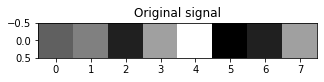

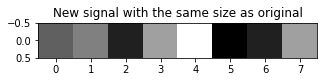

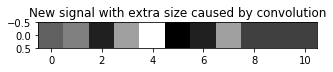

In [3]:
signal = np.array([1, 2, -1, 3, 6, -2, -1, 3])
J = 2

soft_signal, detail_signals = wavelet_1d(signal, haar, J)
new_signal = inversed_wavelet_1d(soft_signal, haar, detail_signals)
clamped_new_signal = new_signal[:len(signal)]
display_image([signal], "Original signal")
display_image([clamped_new_signal], "New signal with the same size as original")
display_image([new_signal], "New signal with extra size caused by convolution")


print(f"Original Signal was {signal} and new signal is {new_signal} ✔️")
print(f"Diferença máxima entre os sinais: {np.max(np.abs(signal - clamped_new_signal))}")

## Questão 2

> Implemente um transformada wavelet 2D (direta e inversa) separável, obtida através da aplicação da transformada 1D nas linhas e/ou colunas da imagem de entrada, conforme visto em aula.
Como saída, deverão ser geradas a imagem suavizada $A_{2^J}[n;m]$, além das imagens de detalhe
$D^{h}_{2^j}[nm]$, $D^{v}_{2^j}[n, m]$ e $D^{d}_{2^j}[n, m]$, para $j = 1, ..., J$. No seu relatório, mostre resultados visuais (imagens) da sua DTW 2D aplicada à imagem __barbara.jpg__, fornecida com o enunciado do trabalho
(a imagem é colorida, você deve primeiramente converter para tons de cinza). Use a _Haar_ com $J = 2$.

### Implementação

In [4]:
def wavelet_2d(image, filters, J=2):
    '''
        Function which applies a 2D wavelet decomposition in `image`.
        The `filters` array must be in the format `[C, D, F, G]`.
        An optional parameter `J` can be passed, to represent how many
        iterations wil be applied to this wavelet.
        
        This function will return the final image signal (`LL`)
        and an array of quadruplets representing the final image
        and the details (`LL`, `LH`, `HL` and `HH`). We return the final
        image on this quadruplet for ease of plotting.
    '''
    C, D, _, _ = filters
    
    details = []
    for _ in range(J):
        # Generating L and H first, to generate LL, LH, HL and HH after
        L = []
        H = []
        for idx, row in enumerate(image):
            y0, y1 = np.convolve(row, C), np.convolve(row, D)
            
            L.append(y0)
            H.append(y1)
        
        # Convert in Numpy arrays to have the `transpose` method
        L = np.array(L)
        H = np.array(H)
        
        LL = []
        LH = []
        for column in L.T:
            y0, y1 = np.convolve(column, C), np.convolve(column, D)
            
            LL.append(y0)
            LH.append(y1)
            
        HL = []
        HH = []
        for column in H.T:
            y0, y1 = np.convolve(column, C), np.convolve(column, D)
            
            HL.append(y0)
            HH.append(y1)
        
        # Downscaling them, and fixing the orientation
        ds_LL = np.array(LL)[1::2, 1::2].T
        ds_LH = np.array(LH)[1::2, 1::2].T
        ds_HL = np.array(HL)[1::2, 1::2].T
        ds_HH = np.array(HH)[1::2, 1::2].T
        
        # Setting up to the next iteration
        image = ds_LL
        
        # We return ds_LL so that we can print it later on
        details.append([ds_LL, ds_LH, ds_HL, ds_HH])
    
    return image, details

def inverse_wavelet_2d(signal, filters, detail_signals=[]):
    '''
        Function which applies an inversed 2D wavelet decomposition in `image`.
        The `filters` array must be in the format `[C, D, F, G]`.
        It receives the detail signals in an array of triplets (`LH`, `HL` and `HH`)
        which will be iterated in reverse to generate the values.
        
        This function returns the original image which generated this signal
        and the detail signals.
    '''
    _, _, F, G = filters
    
    # Inverse transformation
    for idx, detail_signal in enumerate(reversed(detail_signals)):
        ds_LH, ds_HL, ds_HH = detail_signal
        ds_LL = signal
        
        # Upsampling with the not known values as 0
        LL = np.zeros(np.array(ds_LL.shape) * 2)
        LL[::2, ::2] = ds_LL
        LH = np.zeros(np.array(ds_LH.shape) * 2)
        LH[::2, ::2] = ds_LH
        HL = np.zeros(np.array(ds_HL.shape) * 2)
        HL[::2, ::2] = ds_HL
        HH = np.zeros(np.array(ds_HH.shape) * 2)
        HH[::2, ::2] = ds_HH
         
        # Convolution in the upsampled value
        
        # Convolution to go from LL and LH to L
        columns_cLL = []
        columns_cLH = []
        for column_LL, column_LH in zip(LL.T, LH.T):
            column_cLL = np.convolve(column_LL, F)
            column_cLH = np.convolve(column_LH, G)
            
            columns_cLL.append(column_cLL)
            columns_cLH.append(column_cLH)
        
        columns_cLL = np.array(columns_cLL)
        columns_cLH = np.array(columns_cLH)
        
        cLL = []
        cLH = []
        for row_LL, row_LH in zip(columns_cLL.T, columns_cLH.T):
            row_cLL = np.convolve(row_LL, F)
            row_cLH = np.convolve(row_LH, G)
            
            cLL.append(row_cLL)
            cLH.append(row_cLH)
        
        cLL = np.array(cLL)
        cLH = np.array(cLH)
        
        L = cLL + cLH
        
        # Convolution to go from HL and HH to H
        columns_cHL = []
        columns_cHH = []
        for column_HL, column_HH in zip(HL.T, HH.T):
            column_cHL = np.convolve(column_HL, F)
            column_cHH = np.convolve(column_HH, G)
            
            columns_cHL.append(column_cHL)
            columns_cHH.append(column_cHH)
        
        columns_cHL = np.array(columns_cHL)
        columns_cHH = np.array(columns_cHH)
        
        cHL = []
        cHH = []
        for row_HL, row_HH in zip(columns_cHL.T, columns_cHH.T):
            row_cHL = np.convolve(row_HL, F)
            row_cHH = np.convolve(row_HH, G)
            
            cHL.append(row_cHL)
            cHH.append(row_cHH)
        
        cHL = np.array(cHL)
        cHH = np.array(cHH)
        
        H = cHL + cHH

        # Convolution to go from L and H to I
        columns_cL = []
        columns_cH = []
        for column_L, column_H in zip(L.T, H.T):
            column_cL = np.convolve(column_L, F)
            column_cH = np.convolve(column_H, G)
            
            columns_cL.append(column_cL)
            columns_cH.append(column_cH)
        
        columns_cL = np.array(columns_cL)
        columns_cH = np.array(columns_cH)
        
        cL = []
        cH = []
        for row_L, row_H in zip(columns_cL.T, columns_cH.T):
            row_cL = np.convolve(row_L, F)
            row_cH = np.convolve(row_H, G)
            
            cL.append(row_cL)
            cH.append(row_cH)
        
        cL = np.array(cL)
        cH = np.array(cH)
        I = cL + cH
        
        # Pass to the next iteration
        signal = I
        
    return signal


### Resposta

Acima temos a implementação de uma decomposição wavelet 2D (através da função wavelet_2d), além de sua reconstrução (através da função ìnversed_wavelet_2d). Iremos comparar os valores retornados com aqueles retornados pelas funções `dwt2` e `iwt2` da biblioteca `pywt`/PyWavelets (a documentação pode ser encontrada [aqui](https://pywavelets.readthedocs.io/en/latest/)). 

Para a decomposição geramos `L` e `H` iterando sobre as linhas da imagem. Após geramos `LL` (o sinal real), `LH`, `HL` e `HH` iterando sobre as colunas. No final ainda fazemos o _downsampling_ pegando todos os valores nas linhas e colunas impares (isto é, as posições $[(1, 1), (1, 3), (1, 5), ..., (3, 1), (3, 3), ... ]$).

Para a recuperação do valor, iremos iterar sobe a lista de detalhes retornada pela função de decomposição. Primeiro fazemos o _upsample_ de todos os valores `LL, LH, HL, HH`. Para isso geramos uma matriz de $0$'s e preenchemos as posições pares com os valores da matriz original (isto é, as posições $[(0, 0), (0, 2), (0, 4), ..., (2, 0), (2, 2), ...]$) da mesma forma que foi feito na inversa 1D. Após isso fazemos primeira uma convolução nas colunas de `LL` e `LH`, e no resultado disso uma convolução nas linhas. O mesmo acontece com `HL` and `HH`. Geramos `L` somando `LL` com `LH`, e `H` somando `HL` com `HH`. Para gerarmos a imagem I de volta aplicamos o mesmo procedimento de convolução primeiro nas colunas e depois nas linhas de `H` e `L` e somamos o resultado para gerar `I`. Essa imagem `I` é a imagem retornada (podendo ter ocorrido várias iterações desse processo).


Abaixo temos a geração de um gráfico com as imagens geradas quando aplicando `J=3` (no enunciado pedia `J=2`, mas estamos mostrando o valor de `J=2` quando fazemos `J=3` então vamos utilizar `J=3` para exibirmos mais dos resultados. Note como a imagem vai tendo seu tamanho reduzido conforme fazemos mais iterações de _downsample_.

Também geramos como seria o resultado final esperado, nos baseando na aplicação de `pywt.dwt2` `J` vezes também. Podemos então notar que nossa implementação se diferencia da esperada por no máximo $4 * 10^{-13}$, portanto somente erro de precisão computacional.

A fim de testes, se gerarmos 8 iterações (reduzir a imagem a somente 2 pixeis) a diferença é de no máximo $7*10^{-12}$. Para `J=9`, ou seja gerar somente 1 pixel, obtemos __EXATAMENTE__ o mesmo valor nas duas imagens ($56762.77929688$).

Biggest difference between our implementation and pywt.dwt2: 4.547473508864641e-13


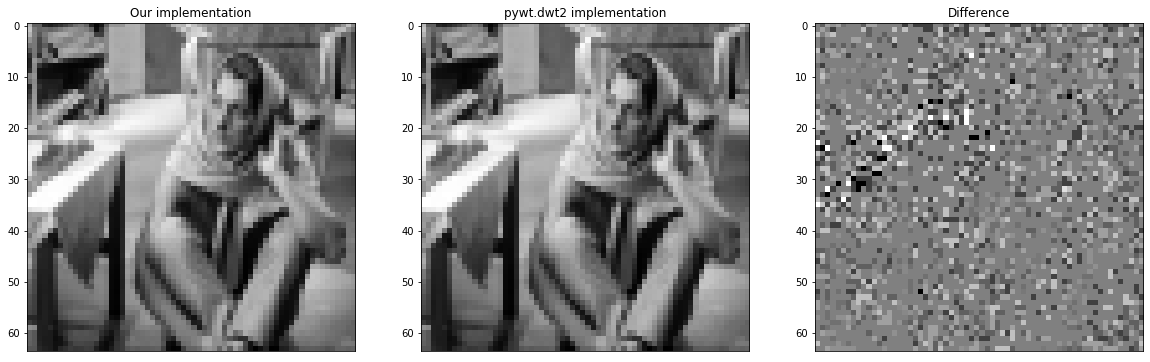

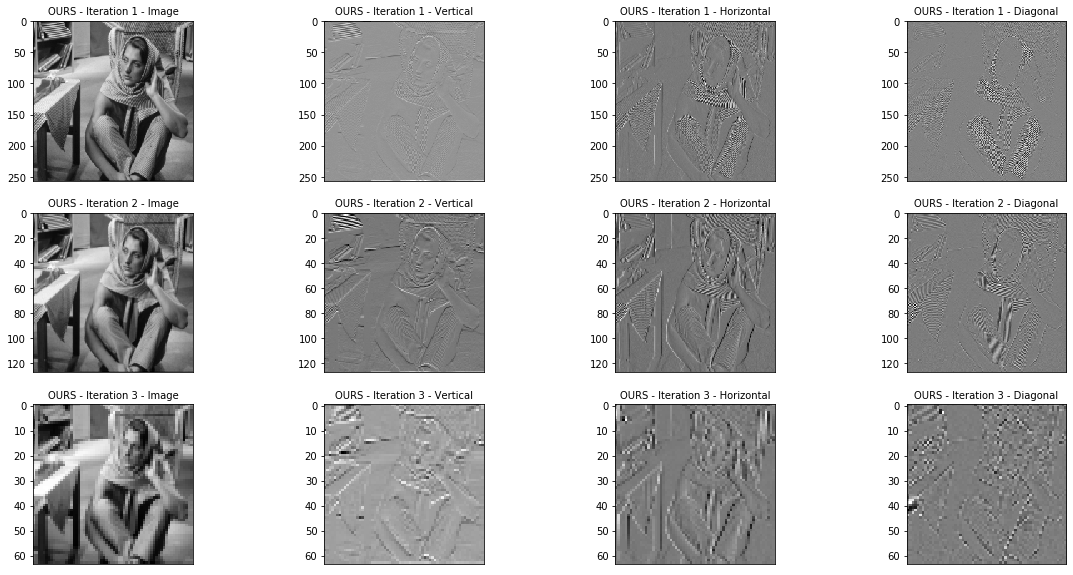

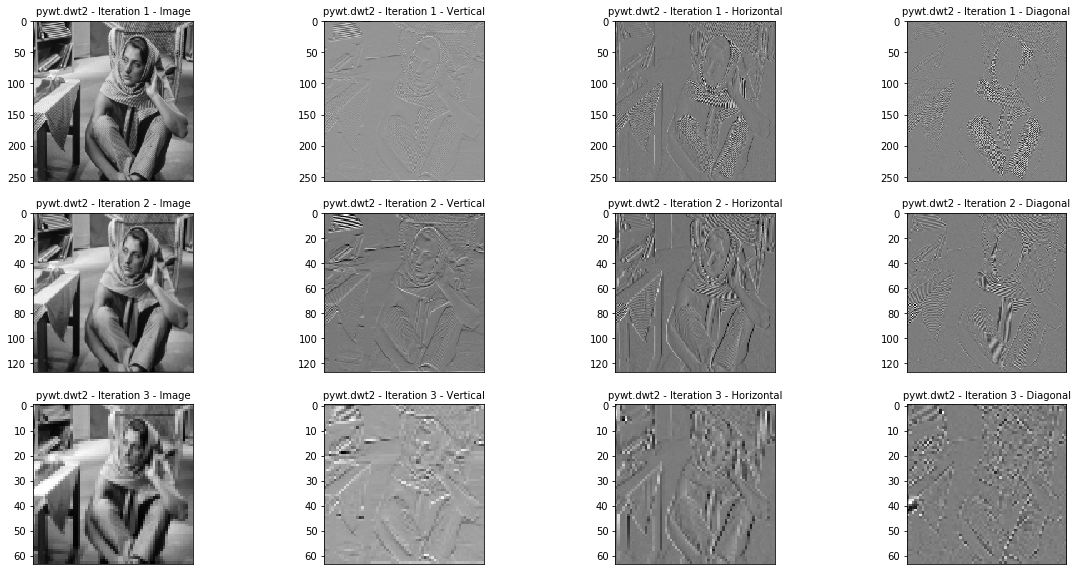

In [5]:
J = 3

# Applying our implementation
image, details = wavelet_2d(barbara, haar, J)

# Applying pywt.dwt2 implementation
image_pywt = barbara
details_pywt = []
for _ in range(J):
    image_pywt, (LH, HL, HH) = pywt.dwt2(image_pywt, 'haar')
    details_pywt.append((image_pywt, LH, HL, HH))
    
difference_image = image_pywt - image

# Comparing our final result and pywt.dwt2
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))
axarr[0].imshow(image, interpolation="nearest", cmap=plt.cm.gray)
axarr[0].set_title(f"Our implementation")
axarr[0].set_xticks([])
axarr[1].imshow(image_pywt, interpolation="nearest", cmap=plt.cm.gray)
axarr[1].set_title(f"pywt.dwt2 implementation")
axarr[1].set_xticks([])
axarr[2].imshow(difference_image, interpolation="nearest", cmap=plt.cm.gray)
axarr[2].set_title(f"Difference")
axarr[2].set_xticks([])
    
# Plotting our implementation
fig, axarr = plt.subplots(J, 4, figsize=(20, 10))
for idx_detail, detail in enumerate(details):
    for idx_inside, img in enumerate(detail):
        axarr[idx_detail, idx_inside].imshow(img, interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_detail, idx_inside].set_title(f"OURS - Iteration {idx_detail + 1} - {titles[idx_inside]}", fontsize=10)
        axarr[idx_detail, idx_inside].set_xticks([])

# Plotting pywt.dwt2 implementation    
fig, axarr = plt.subplots(J, 4, figsize=(20, 10))
for idx_detail, detail in enumerate(details_pywt):
    for idx_inside, img in enumerate(detail):
        axarr[idx_detail, idx_inside].imshow(img, interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_detail, idx_inside].set_title(f"pywt.dwt2 - Iteration {idx_detail + 1} - {titles[idx_inside]}", fontsize=10)
        axarr[idx_detail, idx_inside].set_xticks([])

print(f"Biggest difference between our implementation and pywt.dwt2: {np.max(np.abs(difference_image))}")

Para a reconstrução da imagem, não conseguimos reproduzir os resultados que obtemos com o `pywt.idwt2`, gerando uma imagem extremamente borrada. Repare que ao utilizarmos os __nossos__ detalhes mas com a biblioteca do `pywt` temos o resultado exato, salientando o fato de que a geração dos coeficientes está certa, mas a reconstrução incorreta. Provavelmente isso tem algo a ver com as bordas das imagens quando estamos fazendo as convoluções, já que podemos conferir abaixo que nossa imagem final possui tamanho $(514, 514)$ enquanto o resultado original é $(512, 512)$. 

Our image shape: (514, 514)
pywt.dwt2 image shape: (512, 512)
pywt.dwt2 image with our coefficients shape: (512, 512)


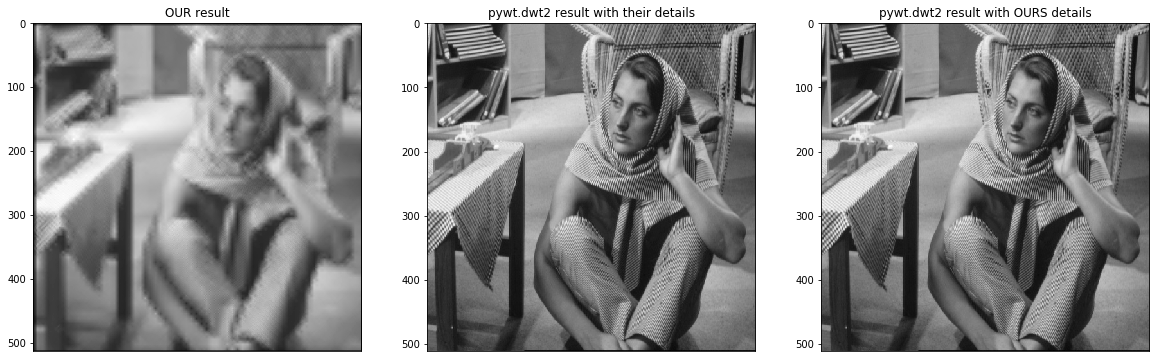

In [6]:
fig, axarr = plt.subplots(1, 3, figsize=(20, 10))

result_image = inverse_wavelet_2d(image, haar, [detail[1:] for detail in details])
axarr[0].imshow(result_image, interpolation="nearest", cmap=plt.cm.gray)
axarr[0].set_title(f"OUR result")
axarr[0].set_xticks([])
print(f"Our image shape: {result_image.shape}")

result_image_pywt = image_pywt
for detail_pywt in reversed(details_pywt):
    merged = (result_image_pywt, detail_pywt[1:])
    result_image_pywt = pywt.idwt2(merged, 'haar')
axarr[1].imshow(result_image_pywt, interpolation="nearest", cmap=plt.cm.gray)
axarr[1].set_title(f"pywt.dwt2 result with their details")
axarr[1].set_xticks([])
print(f"pywt.dwt2 image shape: {result_image_pywt.shape}")

result_image_pywt = image
for detail in reversed(details):
    merged = (result_image_pywt, detail[1:])
    result_image_pywt = pywt.idwt2(merged, 'haar')
axarr[2].imshow(result_image_pywt, interpolation="nearest", cmap=plt.cm.gray)
axarr[2].set_title(f"pywt.dwt2 result with OURS details")
axarr[2].set_xticks([])
print(f"pywt.dwt2 image with our coefficients shape: {result_image_pywt.shape}")


Uma coisa que corrobora com o fato de que o causador disso é as bordas, é que caso compararmos a nossa imagem com a imagem resultante do `pywt.idwt2` podemos notar que temos a imagem correta porém alguma sobreposição dela deslocada (na mesma direção de geração das bordas).

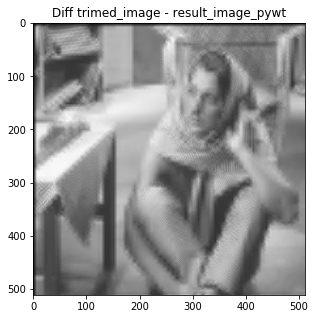

In [7]:
trimmed_image = result_image[:512, :512]
diff = trimmed_image - result_image_pywt
display_image(diff, "Diff trimed_image - result_image_pywt")

## Questão 3

> Uma maneira de remover ruído em imagens é através de soft-thresholding dos coeficientes
wavelet, que consiste em "encolher" os coeficientes de detalhe para zero. Implemente um filtro
redutor de ruído aplicando a seguinte função para o soft-threshold dos coeficientes de detalhe
$T(x) = sgn(x)(|x| - t)_{+}$, onde $sgn(x)$ retorna o sinal de $x$, $t$ é um limiar ajustável, e $x_{+} = max(0, x)$.
Após o soft-thresholding dos coeficientes de detalhes, aplicar a transformada inversa para obter
a imagem filtrada. Nos seus testes, use a imagem _barbara.jpg_ (convertida para tons de cinza)
diretamente, e gere ao menos duas versões ruidosas (ruído Gaussiano aditivo com intensidades
variáveis). Você tem liberdade na escolha da família wavelet. Varie o valor de t e do número de
níveis $J$ na decomposição nos testes, e avalie os resultados obtidos no relatório.

> Dica: Use o módulo _opencv_ da linguagem _Python_ para manipulação e visualização das imagens.

### Implementação

In [8]:
# Implementa aqui @Vini

### Resposta

Escreve a resposta aqui